In [29]:
# from google.colab import drive
# drive.mount('/content/drive')

In [30]:
# %cd "/content/drive/MyDrive/Hust/Age-Gender-Prediction"

In [31]:
# !unzip "./archive.zip" -d '/content/'

## Imports

In [32]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import os
# import cv2
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
import tensorflow as tf

## Data Loading

In [33]:
# colab
# path = '/content/utkface_aligned_cropped/crop_part1/'
# local
path = './data/utkface_aligned_cropped/crop_part1/'

images = []
ages = []
genders = []

for i in os.listdir(path)[0:8000]:
    split = i.split('_')
    ages.append(int(split[0]))
    genders.append(int(split[1]))
    # image = cv2.imread(path+i,0)
    # image = cv2.resize(image,dsize=(200,200,3))
    # image = image.reshape((image.shape[0],image.shape[1],3))
    # images.append(image)
    images.append(Image.open(path + i))

In [34]:
images = pd.Series(list(images), name = 'Images')
ages = pd.Series(list(ages), name = 'Ages')
genders = pd.Series(list(genders), name = 'Genders')

df = pd.concat([images, ages, genders], axis=1)
df

,Images,Ages,Genders
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,100,1
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,100,1
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,101,1
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,10,0
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,10,0
...,...,...,...
7995,<PIL.JpegImagePlugin.JpegImageFile image mode=...,63,1
7996,<PIL.JpegImagePlugin.JpegImageFile image mode=...,63,1
7997,<PIL.JpegImagePlugin.JpegImageFile image mode=...,63,1
7998,<PIL.JpegImagePlugin.JpegImageFile image mode=...,63,1


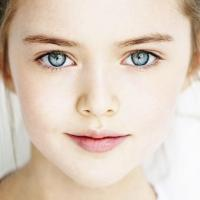

10 Female


In [35]:
display(df['Images'][102])
print(df['Ages'][102], 'Male' if df['Genders'][102] == 0 else 'Female')

<AxesSubplot:>

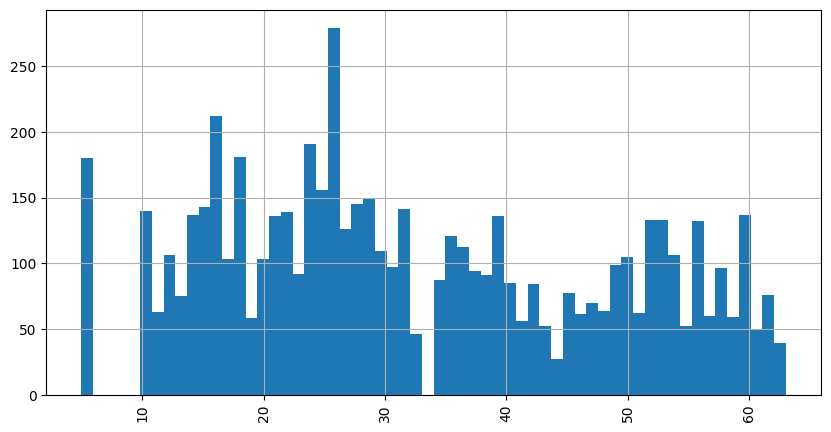

In [36]:
# histogram of df
df = df[df['Ages'] > 4]
df = df[df['Ages'] < 80]
df['Ages'].hist(bins=60, figsize=(10, 5), xrot=90)

<AxesSubplot:>

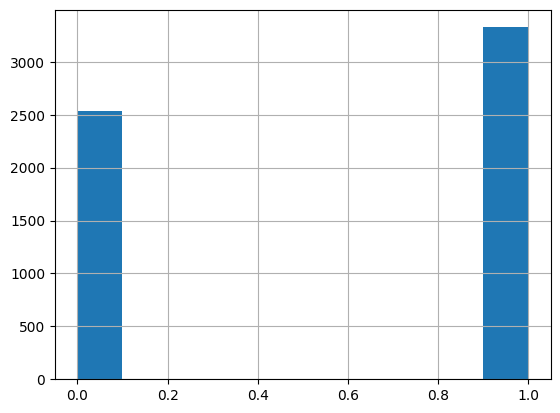

In [37]:
# histogram of df
df = df[df['Genders'] != 3]
df['Genders'].hist()

In [38]:
x = []
y = []

for i in range(len(df)):
    df['Images'].iloc[i] = df['Images'].iloc[i].resize((200,200), Image.ANTIALIAS)
    ar = np.asarray(df['Images'].iloc[i])
    x.append(ar)
    agegen = [int(df['Ages'].iloc[i]), int(df['Genders'].iloc[i])]
    y.append(agegen)

x = np.array(x)


c:\Users\Admin\miniconda3\envs\ai_prj\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  """
c:\Users\Admin\miniconda3\envs\ai_prj\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [39]:
# Train Test split
y_age =  np.array(df['Ages'])
y_gender = np.array(df['Genders'])

x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(x, y_age, test_size=0.2, stratify=y_age)
x_train_gender, x_test_gender, y_train_gender, y_test_gender = train_test_split(x, y_gender, test_size=0.2, stratify=y_gender)

## Training Model

In [40]:
agemodel = Sequential()
agemodel.add(Conv2D(32, (3,3), activation='relu', input_shape=(200, 200, 3)))
agemodel.add(MaxPooling2D((2,2)))
agemodel.add(Conv2D(64, (3,3), activation='relu'))
agemodel.add(MaxPooling2D((2,2)))
agemodel.add(Conv2D(128, (3,3), activation='relu'))
agemodel.add(MaxPooling2D((2,2)))
agemodel.add(Flatten())
agemodel.add(Dense(64, activation='relu'))
agemodel.add(Dropout(0.5))
agemodel.add(Dense(1, activation='relu', name='age_out'))

agemodel.compile(loss='mean_squared_error', optimizer=optimizers.Adam(lr=0.0001))
agemodel.summary()
plot_model(agemodel)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 99, 99, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 23, 23, 128)     

c:\Users\Admin\miniconda3\envs\ai_prj\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [41]:
genmodel = Sequential()
genmodel.add(Conv2D(32, (3,3), activation='relu', input_shape=(200, 200, 3)))
genmodel.add(MaxPooling2D((2,2)))
genmodel.add(Conv2D(64, (3,3), activation='relu'))
genmodel.add(MaxPooling2D((2,2)))
genmodel.add(Conv2D(128, (3,3), activation='relu'))
genmodel.add(MaxPooling2D((2,2)))
genmodel.add(Flatten())
genmodel.add(Dense(64, activation='relu'))
genmodel.add(Dropout(0.5))
genmodel.add(Dense(1, activation='sigmoid', name='gender_out'))

genmodel.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=0.0001), metrics=['accuracy'])
genmodel.summary()
plot_model(genmodel)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 99, 99, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 48, 48, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 46, 46, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 23, 23, 128)     

In [42]:
# Data Generate
datagen = ImageDataGenerator(
      rescale=1./255., width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [43]:
train1 = datagen.flow(x_train_age, y_train_age, batch_size=32)

test1 = test_datagen.flow(
        x_test_age, y_test_age,
        batch_size=32)

history1 = agemodel.fit(train1, epochs=50, shuffle=True, validation_data=test1)

Epoch 1/50
 98/147 [===================>..........] - ETA: 1:16 - loss: 417.8665

In [ ]:
agemodel.save("checkpoints/agemodel.h5")

In [ ]:
train2 = datagen.flow(x_train_gender, y_train_gender, batch_size=64)

test2 = test_datagen.flow(
        x_test_gender, y_test_gender,
        batch_size=64)

history2 = genmodel.fit(train2, epochs=30, shuffle=True, validation_data=test2)

In [ ]:
genmodel.save("checkpoints/genmodel.h5")

In [ ]:
def process_and_predict(file):
    im = Image.open(file)
    width, height = im.size
    if width == height:
        im = im.resize((200,200), Image.ANTIALIAS)
    else:
        if width > height:
            left = width/2 - height/2
            right = width/2 + height/2
            top = 0
            bottom = height
            im = im.crop((left,top,right,bottom))
            im = im.resize((200,200), Image.ANTIALIAS)
        else:
            left = 0
            right = width
            top = 0
            bottom = width
            im = im.crop((left,top,right,bottom))
            im = im.resize((200,200), Image.ANTIALIAS)
            
    ar = np.asarray(im)
    ar = ar.astype('float32')
    ar /= 255.0
    ar = ar.reshape(-1, 200, 200, 3)
    
    age = agemodel.predict(ar)
    gender = np.round(genmodel.predict(ar))
    if gender == 0:
        gender = 'male'
    elif gender == 1:
        gender = 'female'
        
    print('Age:', int(age), '\n Gender:', gender)
    return im.resize((300,300), Image.ANTIALIAS)

-------------------------------------------------------------------------------✈

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

%cd "/content/drive/MyDrive/Hust/Age-Gender-Prediction"


In [ ]:
import os

import tensorflow as tf
from tensorflow import keras

from PIL import Image, ImageOps
from tensorflow.keras.preprocessing.image import load_img
import numpy as np
import matplotlib.pyplot as plt

model = tf.keras.models.load_model("checkpoints/model.h5")
%cd "./testimg"

In [ ]:
%ls

In [ ]:
def testimg(path):
    image = cv2.imread(path, 0)
    image = cv2.resize(image,dsize=(64,64))
    image = image.reshape((image.shape[0],image.shape[1],1))
    display(image)
    res = get_result(image)
    return

In [ ]:
testimg("phuong0.png")
testimg("phuong1.png")
testimg("mixi.png")
testimg("thuytien.png")
testimg("nguoiyeucu.png")
testimg("evans.png")
testimg("littlegirl.png")
